## TNN Programming Assignment B

#### Group Members:
* Mahan Akbari Moghanjoughi
* Aylin Gheisar
* Parham Bagherzadeh
* Peter Roesler

* We decided to use **pytorch** library to implement the multi layer perceptron to complete this assignment. The code from the previous assignment could also be used but with this library we could experiment with numerous optimization and loss algorithms with higher computation speed. Higher level libraries such as sklearn provide easier implementation with just a few function calls but pytorch offers much more flexibility and control over model implementation and layer by layer structure.
* Pytorch is a fundemental library when implementing low level neural networks in python and thus can be simply installed using the pip command:

```
pip install torch
```

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, network_structure):
        super().__init__()
        
        # We can devide this type of network into an encode and a decoder part
        # The choice of tanh for the activation of the hidden layer and softmax for the output layer comes from resources at 
        # https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
        # and experimentation.
        
        # At first RelU was chosen for the hidden layer but sometimes the network would get stuck in a local minima and not improve even with
        # a few several thousand additional training epochs. It might be because Relu is making the neurons less active but choosing tanh as the 
        # activation function made a huge improvement in both performance and convergance time.
        self.encoder = nn.Sequential(
            nn.Linear(network_structure[0], network_structure[1]),
            nn.Tanh()
        )
        
        # The choice of softmax at the output was more straightforward because we are trying to achieve multi class
        # classification, the softmax function turns the output of the final layer into a probability distribution between classes. At first the
        # output layer had linear activation because i thought you only needed it to choose the output label, but putting it into the structure 
        # greatly reduced the convergance time, so I believe it helps with loss calculation.
        self.decoder = nn.Sequential(
            nn.Linear(network_structure[1], network_structure[2]),
            nn.Softmax(dim=1),
        )

    # Feed forward is passing data through the encoder and the decder layer
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded
    
    # Pytorch gives us much more control over the functionaly of the network, we can feed forward the network only halfway through and into the 
    # encoder layer to take a look into the hidden layers.
    def get_encoded_hidden_neurons(self, x):
        model.eval()
        with torch.no_grad():
            encoded = self.encoder(x)
        
        return encoded
    
    # For prediction the probabillity distribution that the last softmax layer generates is turned into binary one-hot encoded output
    def predict(self, x):
        model.eval()
        with torch.no_grad():
            pred = model(x)

            y = torch.zeros_like(pred)
            y[range(y.shape[0]), pred.argmax(dim=1)] = 1
        
        return y

## 8-3-8 encoder/decoder

In [3]:
# For 8-3-8 encoder the training data is simple enough that I inputed by hand for demonstration
X = [[1, 0, 0, 0, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 0, 0, 1]]
     
# Desired output is getting the same data as the input
y = X.copy()

# We need to convert our lists into tensor datatype for pytorch to work with them
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [4]:
model = NeuralNetwork(network_structure=(8, 3, 8))

# Choosing the loss function was made using experimentation and this resource https://www.v7labs.com/blog/pytorch-loss-functions.
# Simply, mean squared error does not give high enough error for a misclassification of 0 and 1. I read that cross entropy loss is more effective
# for classification purposes but still convergance was slow for both mse and cross entropy loss. I came across Binary Cross Entropy which is
# intended for binary outputs for classification. It allowed faster and more consistent convergance.
loss_fn = nn.BCELoss()

In [5]:
# Choice of optimization algorithm and the hyper parameters was done using the learning curve. Stochastic gradient descent at first gave very bad
# results; so I tested the network with adam optimizer which worked prefectly but was overkill for this task. So I debugged the SGD algorithm and 
# using the learning curve found out that my default value of 0.001 was way too little for this task and the optimal learning rate was arount 1.
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters())

In [6]:
max_epoch = 1000

train_loss = torch.zeros((max_epoch,)).detach().numpy()

model.train()
for epoch in range(max_epoch):
    # Compute error
    pred = model(X)
    loss = loss_fn(pred, y)
    
    # Backpropagation for a single step 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # We cache the loss to plot the learning curve
    train_loss[epoch] = loss

    if epoch % 100 == 0:
        loss, current = loss.item(), (epoch + 1)
        print(f"loss: {loss:>7f}  [{current:>3d}/{max_epoch:>3d}]")

/opt/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1673738523684/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


loss: 0.372760  [  1/1000]
loss: 0.228326  [101/1000]
loss: 0.108997  [201/1000]
loss: 0.058128  [301/1000]
loss: 0.036226  [401/1000]
loss: 0.025066  [501/1000]
loss: 0.018790  [601/1000]
loss: 0.014904  [701/1000]
loss: 0.012301  [801/1000]
loss: 0.010447  [901/1000]


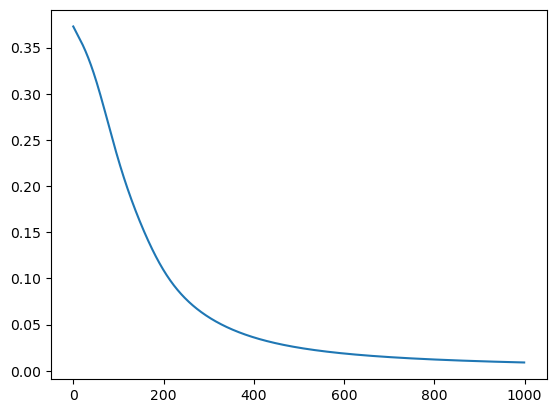

In [7]:
# We plot the learning curve
plt.plot(train_loss)
plt.show()

In [8]:
# The model outputs the right values for all instances of X
model.predict(X)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

In [9]:
# We can take a look at the activation values of the hidden (encoder) neurons
model.get_encoded_hidden_neurons(X)

tensor([[ 0.6874, -0.9677, -0.9019],
        [-0.3920,  0.8436, -0.9677],
        [-0.9161, -0.8230,  0.9638],
        [-0.9726, -0.8358, -0.8432],
        [-0.9528,  0.9602,  0.5164],
        [ 0.9749,  0.8396, -0.6586],
        [ 0.6735,  0.9094,  0.9565],
        [ 0.9347, -0.9389,  0.9307]])

In [10]:
# By setting a threshold (0 in this case) we can see that the network has learned to encode the input into binary numbers
model.get_encoded_hidden_neurons(X) > 0

tensor([[ True, False, False],
        [False,  True, False],
        [False, False,  True],
        [False, False, False],
        [False,  True,  True],
        [ True,  True, False],
        [ True,  True,  True],
        [ True, False,  True]])

## 8-2-8 encoder/decoder

In [11]:
# The training data stays the same for this task as well
X = [[1, 0, 0, 0, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 0, 0, 1]]
     
y = X.copy()

X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [12]:
# We change the network structure to 8, 2, 8
model = NeuralNetwork(network_structure=(8, 2, 8))

# The choice of loss and optimizer algorithms remains efficient throughout this task type, so they remain the same
loss_fn = nn.BCELoss()

learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
max_epoch = 1000

train_loss = torch.zeros((max_epoch,)).detach().numpy()

model.train()
for epoch in range(max_epoch):
    # Compute error
    pred = model(X)
    loss = loss_fn(pred, y)
    
    # Backpropagation for a single step 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # We cache the loss to plot the learning curve
    train_loss[epoch] = loss

    if epoch % 100 == 0:
        loss, current = loss.item(), (epoch + 1)
        print(f"loss: {loss:>7f}  [{current:>3d}/{max_epoch:>3d}]")

loss: 0.385014  [  1/1000]
loss: 0.269723  [101/1000]
loss: 0.198674  [201/1000]
loss: 0.165235  [301/1000]
loss: 0.139024  [401/1000]
loss: 0.115736  [501/1000]
loss: 0.096974  [601/1000]
loss: 0.082411  [701/1000]
loss: 0.071092  [801/1000]
loss: 0.062151  [901/1000]


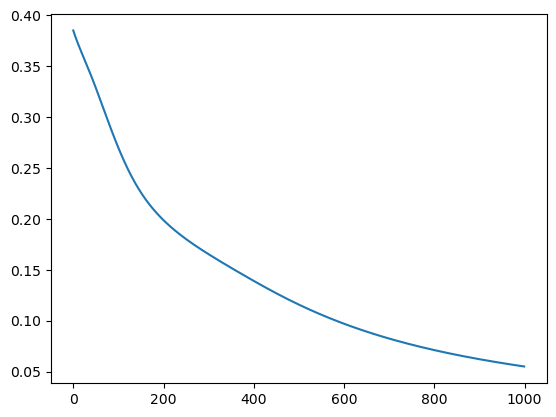

In [14]:
# We observe that learning curve is less steeper than the last task, but convergance is still reached in 1000 steps
plt.plot(train_loss)
plt.show()

In [15]:
# The model still outputs the right values for all instances of X
model.predict(X)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

In [16]:
# We can take a look at the activation values of the hidden (encoder) neurons
model.get_encoded_hidden_neurons(X)

tensor([[ 0.9795,  0.1002],
        [ 0.9741, -0.9766],
        [-0.9814, -0.9504],
        [ 0.7534,  0.9835],
        [-0.0171, -0.9838],
        [ 0.0323,  0.0517],
        [-0.9741,  0.0990],
        [-0.9089,  0.9785]])

In [17]:
# This time unique binary patterns are not present and the input is encoded as continous numbers
model.get_encoded_hidden_neurons(X) > 0

tensor([[ True,  True],
        [ True, False],
        [False, False],
        [ True,  True],
        [False, False],
        [ True,  True],
        [False,  True],
        [False,  True]])

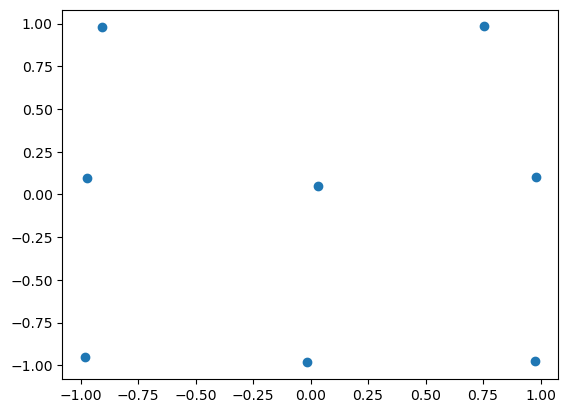

In [18]:
# plotting the values of the hidden neurons shows that the previous layer has been trying to make the states linearly seperable
encoded = model.get_encoded_hidden_neurons(X)
plt.scatter(encoded[:, 0], encoded[:, 1])
plt.show()

## 64-6-64 encoder/decoder

In [19]:
# We can generate the training data of one-hot encoded numbers simply by generating a 64*64 identity matrix with pytorch
X = torch.eye(64)
y = X.clone()

In [20]:
# We change the network structure to 64, 6, 64
model = NeuralNetwork(network_structure=(64, 6, 64))

loss_fn = nn.BCELoss()

# Choosing the learning rate for this problem was really fascinating as it turned out that a learning rate of 100 was ideal to converge in
# 1000 epochs, it seemed like I could increase the rate to converge even faster. So I believe the error surface for this task might be very flat
learning_rate = 100
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
max_epoch = 1000

train_loss = torch.zeros((max_epoch,)).detach().numpy()

model.train()
for epoch in range(max_epoch):
    # Compute error
    pred = model(X)
    loss = loss_fn(pred, y)
    
    # Backpropagation for a single step 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # We cache the loss to plot the learning curve
    train_loss[epoch] = loss

    if epoch % 100 == 0:
        loss, current = loss.item(), (epoch + 1)
        print(f"loss: {loss:>7f}  [{current:>3d}/{max_epoch:>3d}]")

loss: 0.080970  [  1/1000]
loss: 0.046635  [101/1000]
loss: 0.019962  [201/1000]
loss: 0.009735  [301/1000]
loss: 0.005755  [401/1000]
loss: 0.003955  [501/1000]
loss: 0.002971  [601/1000]
loss: 0.002362  [701/1000]
loss: 0.001953  [801/1000]
loss: 0.001661  [901/1000]


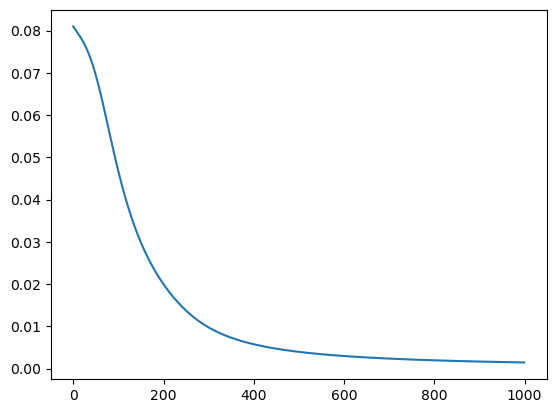

In [22]:
# the learning curve stablizes in around 600 epochs with the huge learning rate
plt.plot(train_loss)
plt.show()

In [23]:
# The model still outputs the right values for all instances of X
model.predict(X) == X

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [24]:
model.predict(X).argmax(dim=1)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [25]:
# The activation values of the hidden neurons (seem to be) encoding for 6 bit numbers
model.get_encoded_hidden_neurons(X)

tensor([[-0.8235,  0.9450, -0.9733, -0.9032, -0.3399,  0.9416],
        [-0.1659, -0.8712,  0.8609,  0.9077, -0.9795,  0.9627],
        [-0.8341,  0.4312,  0.2890, -0.9830,  0.1353,  0.9752],
        [-0.9394, -0.9540, -0.9747, -0.5680,  0.9575, -0.5411],
        [ 0.9477,  0.9242, -0.3255, -0.9615, -0.9578,  0.9599],
        [ 0.1195,  0.9272, -0.9754,  0.9012,  0.9576,  0.8372],
        [-0.4481, -0.8738,  0.2608, -0.9832,  0.6170, -0.9727],
        [-0.9513, -0.9720,  0.7957,  0.4873, -0.9483, -0.9151],
        [-0.9482, -0.9564,  0.6825, -0.8811, -0.9674,  0.9358],
        [-0.2585,  0.9641, -0.9460, -0.9334, -0.9786, -0.5385],
        [ 0.9552,  0.6980, -0.9684,  0.3679, -0.9677,  0.1080],
        [-0.9697,  0.3348, -0.9653, -0.9632,  0.0711, -0.9388],
        [ 0.8695,  0.8886,  0.3046,  0.9752, -0.3358, -0.9669],
        [ 0.9725,  0.9213, -0.9532, -0.9374, -0.1680, -0.9562],
        [ 0.9482,  0.9117,  0.9468,  0.9604, -0.9711,  0.7789],
        [ 0.1185, -0.8173, -0.9610,  0.9

## [Attempt at] 50-2-50 encoder/decoder

In [26]:
# We can generate the training data of one-hot encoded numbers simply by generating a 50*50 identity matrix with pytorch
X = torch.eye(50)
y = X.clone()

In [27]:
# We change the network structure to 50, 2, 50
model = NeuralNetwork(network_structure=(50, 2, 50))

loss_fn = nn.BCELoss()

# I was not able to make the model converge on simple SGD with any of the hyper parameters. I tried adjusting the learning rate, momentum, decay.
# Adam optimizer seemed to converge well by adjusting the learning rate

# learning_rate = 20
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
# We also need to train the model for longer
max_epoch = 5000

train_loss = torch.zeros((max_epoch,)).detach().numpy()

model.train()
for epoch in range(max_epoch):
    # Compute error
    pred = model(X)
    loss = loss_fn(pred, y)
    
    # Backpropagation for a single step 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # We cache the loss to plot the learning curve
    train_loss[epoch] = loss

    if epoch % 100 == 0:
        loss, current = loss.item(), (epoch + 1)
        print(f"loss: {loss:>7f}  [{current:>3d}/{max_epoch:>3d}]")

loss: 0.099747  [  1/5000]
loss: 0.052825  [101/5000]
loss: 0.044469  [201/5000]
loss: 0.039061  [301/5000]
loss: 0.035189  [401/5000]
loss: 0.032430  [501/5000]
loss: 0.029475  [601/5000]
loss: 0.026153  [701/5000]
loss: 0.023152  [801/5000]
loss: 0.021220  [901/5000]
loss: 0.018856  [1001/5000]
loss: 0.017761  [1101/5000]
loss: 0.017030  [1201/5000]
loss: 0.015799  [1301/5000]
loss: 0.015224  [1401/5000]
loss: 0.014746  [1501/5000]
loss: 0.014166  [1601/5000]
loss: 0.013742  [1701/5000]
loss: 0.013467  [1801/5000]
loss: 0.011445  [1901/5000]
loss: 0.011055  [2001/5000]
loss: 0.009599  [2101/5000]
loss: 0.009239  [2201/5000]
loss: 0.009056  [2301/5000]
loss: 0.008852  [2401/5000]
loss: 0.007777  [2501/5000]
loss: 0.007565  [2601/5000]
loss: 0.007397  [2701/5000]
loss: 0.007250  [2801/5000]
loss: 0.006731  [2901/5000]
loss: 0.006139  [3001/5000]
loss: 0.005994  [3101/5000]
loss: 0.005875  [3201/5000]
loss: 0.005765  [3301/5000]
loss: 0.005668  [3401/5000]
loss: 0.005586  [3501/5000]
lo

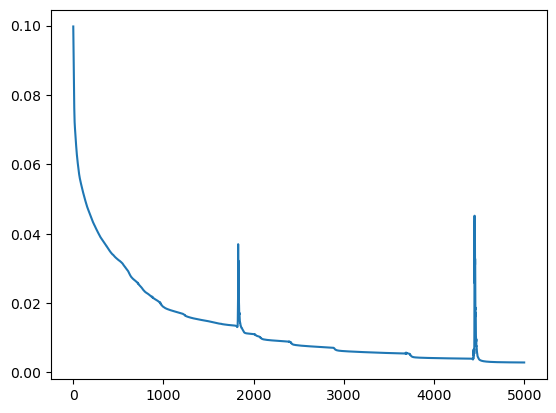

In [29]:
# The error always seems to spike during the training. This might be an artifact of the learning algorithm.
plt.plot(train_loss)
plt.show()

In [30]:
# The model succeeds in encoding 50 states into 2 hidden neurons
model.predict(X) == X

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [31]:
model.predict(X).argmax(dim=1)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 27, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [32]:
# Reading the hidden activation values won't help in understanding the function of the network
model.get_encoded_hidden_neurons(X)[:10]

tensor([[ 0.1843, -0.3863],
        [-1.0000, -0.6899],
        [-0.6928, -0.8796],
        [ 0.5785,  0.7117],
        [-0.3986,  1.0000],
        [ 0.6425,  0.0107],
        [ 0.7077,  0.3596],
        [-0.5953,  0.1731],
        [-0.0369, -1.0000],
        [ 1.0000, -0.4785]])

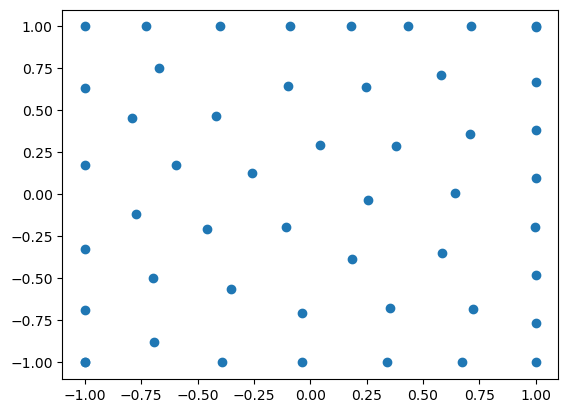

In [33]:
# plotting the values of the hidden neurons shows that the previous layer has been trying to make the states linearly seperable
encoded = model.get_encoded_hidden_neurons(X)
plt.scatter(encoded[:, 0], encoded[:, 1])
plt.show()